In [1]:
"""
═══════════════════════════════════════════════════════════════════════════════
    LightGCL Hybrid Recommendation System
    Amazon Reviews 2023 - Handmade Products
    Optimized for Kaggle Notebook
═══════════════════════════════════════════════════════════════════════════════
"""

# ═══════════════════════════════════════════════════════════════════════════
# CELL 1: SETUP & INSTALLATION
# ═══════════════════════════════════════════════════════════════════════════

print("Installing required packages...")
!pip install -q sentence-transformers

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
from tqdm.notebook import tqdm
import json
import gzip
import warnings
import os
import gc
warnings.filterwarnings('ignore')

print("✓ All packages imported successfully!")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*70}")
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"{'='*70}\n")

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all

2025-12-28 15:50:54.474677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766937054.705273      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766937054.770756      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✓ All packages imported successfully!

Device: cpu



In [2]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 2: CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# ────────────────── KAGGLE PATHS ──────────────────
# Add Amazon 2023 dataset via "Add Data" in Kaggle
# Search for: "Amazon Reviews 2023"
KAGGLE_INPUT_PATH = '/kaggle/input'  # Kaggle input directory

# If you uploaded data manually:
REVIEW_PATH = None  # Will auto-detect
META_PATH = None    # Will auto-detect

# ────────────────── DATA CONFIGURATION ──────────────────
MAX_REVIEWS = None
MIN_USER_INTERACTIONS = 3
MIN_ITEM_INTERACTIONS = 3

# ────────────────── MODEL CONFIGURATION ──────────────────
EMBED_DIM = 64
N_LAYERS = 3
TEXT_BATCH_SIZE = 32
TRAIN_BATCH_SIZE = 512  # Kaggle GPU can handle this
EPOCHS = 20  # Reduce for Kaggle time limit
LR = 0.001
ALPHA = 0.7  # Weight for rating loss
BETA = 0.3   # Weight for contrastive loss

# ────────────────── OUTPUT ──────────────────
OUTPUT_DIR = '/kaggle/working'
MODEL_SAVE_PATH = f'{OUTPUT_DIR}/lightgcl_best.pth'

print("Configuration:")
print(f"  Max Reviews: {MAX_REVIEWS if MAX_REVIEWS else 'All'}")
print(f"  Device: {device}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")

Configuration:
  Max Reviews: All
  Device: cpu
  Batch Size: 512
  Epochs: 20


In [3]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 3: DATA LOADING FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def find_data_files():
    """Auto-detect data files in Kaggle input"""
    print("Searching for data files...")
    
    review_file = None
    meta_file = None
    
    # Search in Kaggle input directory
    for root, dirs, files in os.walk(KAGGLE_INPUT_PATH):
        for file in files:
            if 'review' in file.lower() and file.endswith('.jsonl.gz'):
                review_file = os.path.join(root, file)
                print(f"✓ Found reviews: {review_file}")
            elif 'meta' in file.lower() and file.endswith('.jsonl.gz'):
                meta_file = os.path.join(root, file)
                print(f"✓ Found metadata: {meta_file}")
    
    if not review_file or not meta_file:
        print("\n⚠️  Data files not found!")
        print("Please add Amazon Reviews 2023 dataset via Kaggle 'Add Data'")
        print("Search for: 'Amazon Reviews 2023' or 'Amazon Reviews 2023 Handmade'")
        raise FileNotFoundError("Required data files not found")
    
    return review_file, meta_file

def load_jsonl_gz(file_path, max_rows=None):
    """Load JSONL.gz file efficiently"""
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading {os.path.basename(file_path)}")):
            if max_rows and i >= max_rows:
                break
            try:
                data.append(json.loads(line.strip()))
            except:
                continue
    return pd.DataFrame(data)

In [4]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 4: DATA PREPROCESSING
# ═══════════════════════════════════════════════════════════════════════════

class DataPreprocessor:
    """Efficient data preprocessing for Kaggle"""
    
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.cat_encoder = LabelEncoder()
        
    def filter_kcore(self, df, min_user, min_item):
        """K-core filtering"""
        print(f"K-core filtering (min_user={min_user}, min_item={min_item})...")
        
        prev_len = 0
        while len(df) != prev_len:
            prev_len = len(df)
            user_counts = df['user_id'].value_counts()
            item_counts = df['parent_asin'].value_counts()
            df = df[df['user_id'].isin(user_counts[user_counts >= min_user].index)]
            df = df[df['parent_asin'].isin(item_counts[item_counts >= min_item].index)]
        
        print(f"  After k-core: {len(df)} interactions")
        return df
    
    def preprocess_reviews(self, reviews_df, meta_df):
        """Main preprocessing pipeline"""
        print("\n" + "="*70)
        print("PREPROCESSING")
        print("="*70)
        
        # 1. K-core filtering
        reviews_df = self.filter_kcore(reviews_df, MIN_USER_INTERACTIONS, MIN_ITEM_INTERACTIONS)
        
        # 2. Merge with metadata
        print("\nMerging with metadata...")
        df = reviews_df.merge(
            meta_df[['parent_asin', 'title', 'price', 'categories', 'main_category']],
            on='parent_asin',
            how='left'
        )
        
        # 3. Handle missing values
        print("Handling missing values...")
        df['rating'] = df['rating'].fillna(df['rating'].mean())
        df['text'] = df['text'].fillna('')
        df['title_x'] = df['title_x'].fillna('')  # Review title
        df['title_y'] = df['title_y'].fillna('')  # Product title
        df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0)
        df['main_category'] = df['main_category'].fillna('Unknown')
        
        # 4. Encode IDs
        print("Encoding IDs...")
        df['user_idx'] = self.user_encoder.fit_transform(df['user_id'])
        df['item_idx'] = self.item_encoder.fit_transform(df['parent_asin'])
        df['category_idx'] = self.cat_encoder.fit_transform(df['main_category'])
        
        print(f"\n✓ Preprocessed:")
        print(f"  Interactions: {len(df):,}")
        print(f"  Users: {df['user_idx'].nunique():,}")
        print(f"  Items: {df['item_idx'].nunique():,}")
        print(f"  Sparsity: {1 - len(df)/(df['user_idx'].nunique()*df['item_idx'].nunique()):.4f}")
        
        return df
    
    def encode_text(self, df, batch_size=32):
        """Encode text with Sentence-BERT"""
        print("\nEncoding text features...")
        print("Loading Sentence-BERT model...")
        
        encoder = SentenceTransformer('all-MiniLM-L6-v2')
        
        # Combine text
        texts = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Preparing text"):
            text = f"{row['title_x']} {row['text']} {row['title_y']}"[:512]
            texts.append(text)
        
        # Encode
        embeddings = encoder.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            device=device.type
        )
        
        print(f"✓ Text embeddings: {embeddings.shape}")
        
        # Free memory
        del encoder
        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        
        return embeddings

In [5]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 5: GRAPH CONSTRUCTION
# ═══════════════════════════════════════════════════════════════════════════

def build_bipartite_graph(df):
    """Build user-item bipartite graph"""
    print("\n" + "="*70)
    print("BUILDING GRAPH")
    print("="*70)
    
    n_users = df['user_idx'].max() + 1
    n_items = df['item_idx'].max() + 1
    
    print(f"Users: {n_users}, Items: {n_items}")
    
    # User-item matrix
    row = df['user_idx'].values
    col = df['item_idx'].values
    data = (df['rating'].values >= 0).astype(float)  # Implicit feedback
    
    user_item = sp.csr_matrix((data, (row, col)), shape=(n_users, n_items))
    
    # Bipartite adjacency
    adj = sp.bmat([[None, user_item], [user_item.T, None]])
    adj = adj + sp.eye(adj.shape[0])
    
    # Normalize
    degrees = np.array(adj.sum(axis=1)).flatten()
    d_inv_sqrt = np.power(degrees, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat = sp.diags(d_inv_sqrt)
    norm_adj = d_mat @ adj @ d_mat
    
    print(f"✓ Graph: {adj.shape[0]} nodes, {user_item.nnz} edges")
    
    return norm_adj, n_users, n_items

def sparse_to_torch(sparse_matrix, device):
    """Convert scipy sparse to torch sparse tensor"""
    coo = sparse_matrix.tocoo()
    indices = torch.LongTensor([coo.row, coo.col])
    values = torch.FloatTensor(coo.data)
    return torch.sparse_coo_tensor(indices, values, coo.shape).to(device)

In [6]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 6: MODEL DEFINITION
# ═══════════════════════════════════════════════════════════════════════════

class LightGCL(nn.Module):
    """LightGCL for collaborative filtering"""
    
    def __init__(self, n_users, n_items, embed_dim=64, n_layers=3):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, embed_dim)
        self.item_embedding = nn.Embedding(n_items, embed_dim)
        
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
    
    def forward(self, norm_adj):
        ego_embeddings = torch.cat([
            self.user_embedding.weight,
            self.item_embedding.weight
        ], dim=0)
        
        all_embeddings = [ego_embeddings]
        
        for _ in range(self.n_layers):
            ego_embeddings = torch.sparse.mm(norm_adj, ego_embeddings)
            all_embeddings.append(ego_embeddings)
        
        final_embeddings = torch.stack(all_embeddings, dim=1).mean(dim=1)
        user_emb, item_emb = torch.split(final_embeddings, [self.n_users, self.n_items])
        
        return user_emb, item_emb

class HybridRecommender(nn.Module):
    """Hybrid: LightGCL + Content"""
    
    def __init__(self, n_users, n_items, n_categories, text_dim=384, embed_dim=64):
        super().__init__()
        
        self.lightgcl = LightGCL(n_users, n_items, embed_dim, N_LAYERS)
        
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.cat_embedding = nn.Embedding(n_categories, 32)
        
        self.fusion = nn.Sequential(
            nn.Linear(embed_dim + 128 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, user_ids, item_ids, text_feats, categories, norm_adj):
        user_emb, item_emb = self.lightgcl(norm_adj)
        
        cf_emb = user_emb[user_ids] * item_emb[item_ids]
        text_emb = self.text_proj(text_feats)
        cat_emb = self.cat_embedding(categories)
        
        combined = torch.cat([cf_emb, text_emb, cat_emb], dim=1)
        pred = self.fusion(combined).squeeze()
        
        return pred

In [7]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 7: DATASET & DATALOADER
# ═══════════════════════════════════════════════════════════════════════════

class RecDataset(Dataset):
    def __init__(self, df, text_features):
        self.user_ids = torch.LongTensor(df['user_idx'].values)
        self.item_ids = torch.LongTensor(df['item_idx'].values)
        self.ratings = torch.FloatTensor(df['rating'].values)
        self.categories = torch.LongTensor(df['category_idx'].values)
        self.text_features = torch.FloatTensor(text_features)
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        return {
            'user_id': self.user_ids[idx],
            'item_id': self.item_ids[idx],
            'rating': self.ratings[idx],
            'category': self.categories[idx],
            'text': self.text_features[idx]
        }

In [8]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 8: TRAINING FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def train_epoch(model, dataloader, norm_adj, optimizer):
    model.train()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch in pbar:
        user_ids = batch['user_id'].to(device)
        item_ids = batch['item_id'].to(device)
        ratings = batch['rating'].to(device)
        categories = batch['category'].to(device)
        text_feats = batch['text'].to(device)
        
        optimizer.zero_grad()
        
        pred = model(user_ids, item_ids, text_feats, categories, norm_adj)
        loss = F.mse_loss(pred, ratings)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(dataloader)

@torch.no_grad()
def evaluate(model, dataloader, norm_adj):
    model.eval()
    total_mse = 0
    
    for batch in tqdm(dataloader, desc="Evaluating", leave=False):
        user_ids = batch['user_id'].to(device)
        item_ids = batch['item_id'].to(device)
        ratings = batch['rating'].to(device)
        categories = batch['category'].to(device)
        text_feats = batch['text'].to(device)
        
        pred = model(user_ids, item_ids, text_feats, categories, norm_adj)
        total_mse += F.mse_loss(pred, ratings).item()
    
    rmse = np.sqrt(total_mse / len(dataloader))
    return rmse

In [9]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

!wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Handmade_Products.jsonl.gz
!wget https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Handmade_Products.jsonl.gz


--2025-12-28 15:51:21--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Handmade_Products.jsonl.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77803288 (74M) [application/gzip]
Saving to: ‘Handmade_Products.jsonl.gz’

Handmade_Products.j 100%[===================>]  74.20M  22.0MB/s    in 4.2s    

2025-12-28 15:51:26 (17.6 MB/s) - ‘Handmade_Products.jsonl.gz’ saved [77803288/77803288]

--2025-12-28 15:51:26--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Handmade_Products.jsonl.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94391206 (90M) [application/gzip]
Saving to: ‘meta_Hand

In [10]:
!gunzip /kaggle/working/Handmade_Products.jsonl.gz
!gunzip /kaggle/working/meta_Handmade_Products.jsonl.gz

In [11]:
reviews_df = load_jsonl('/kaggle/working/Handmade_Products.jsonl')
meta_df = load_jsonl('/kaggle/working/meta_Handmade_Products.jsonl')

In [12]:
def precision_at_k(actual, predicted, k):
    """
    Precision@K: proportion of recommended items that are relevant
    
    Args:
        actual: set of actual relevant items
        predicted: list of predicted items (ranked)
        k: cutoff
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    
    if len(actual) == 0:
        return 0.0
    
    num_hits = len(set(predicted) & set(actual))
    return num_hits / min(len(predicted), k)

def recall_at_k(actual, predicted, k):
    """
    Recall@K: proportion of relevant items that are recommended
    
    Args:
        actual: set of actual relevant items
        predicted: list of predicted items (ranked)
        k: cutoff
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    
    if len(actual) == 0:
        return 0.0
    
    num_hits = len(set(predicted) & set(actual))
    return num_hits / len(actual)

def ndcg_at_k(actual, predicted, k):
    """
    Normalized Discounted Cumulative Gain@K
    
    Args:
        actual: set of actual relevant items
        predicted: list of predicted items (ranked)
        k: cutoff
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    
    if len(actual) == 0:
        return 0.0
    
    # DCG
    dcg = 0.0
    for i, item in enumerate(predicted):
        if item in actual:
            dcg += 1.0 / np.log2(i + 2)  # i+2 because index starts at 0
    
    # IDCG (ideal DCG)
    idcg = 0.0
    for i in range(min(len(actual), k)):
        idcg += 1.0 / np.log2(i + 2)
    
    if idcg == 0:
        return 0.0
    
    return dcg / idcg

def evaluate_ranking_metrics(model, user_item_dict, test_user_item_dict, 
                             norm_adj, n_users, n_items, k_list=[10, 50]):
    """
    Evaluate ranking metrics for all test users
    
    Args:
        user_item_dict: dict mapping user_idx to list of all interacted items (for filtering)
        test_user_item_dict: dict mapping user_idx to list of test items (ground truth)
        k_list: list of K values to evaluate
    """
    model.eval()
    
    metrics = {f'precision@{k}': [] for k in k_list}
    metrics.update({f'recall@{k}': [] for k in k_list})
    metrics.update({f'ndcg@{k}': [] for k in k_list})
    
    with torch.no_grad():
        # Get all embeddings
        user_emb, item_emb = model.lightgcl(norm_adj)
        
        # Evaluate for each test user
        for user_idx in tqdm(test_user_item_dict.keys(), desc="Evaluating users", leave=False):
            # Get user embedding
            user_vec = user_emb[user_idx].unsqueeze(0)
            
            # Compute scores for all items
            scores = (user_vec @ item_emb.T).squeeze().cpu().numpy()
            
            # Filter out training items (don't recommend items user already interacted with)
            train_items = user_item_dict.get(user_idx, [])
            scores[train_items] = -np.inf
            
            # Get ground truth test items
            test_items = test_user_item_dict[user_idx]
            
            # For each K
            for k in k_list:
                # Get top-K predictions
                top_k_items = np.argsort(scores)[-k:][::-1].tolist()
                
                # Calculate metrics
                metrics[f'precision@{k}'].append(precision_at_k(test_items, top_k_items, k))
                metrics[f'recall@{k}'].append(recall_at_k(test_items, top_k_items, k))
                metrics[f'ndcg@{k}'].append(ndcg_at_k(test_items, top_k_items, k))
    
    # Average metrics
    avg_metrics = {key: np.mean(values) for key, values in metrics.items()}
    
    return avg_metrics


In [13]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 9: LOAD DATA
# ═══════════════════════════════════════════════════════════════════════════

print("="*70)
print("LOADING DATA")
print("="*70)



print(f"\n✓ Loaded {len(reviews_df)} reviews")
print(f"✓ Loaded {len(meta_df)} metadata")

# Quick peek
print("\nSample review:")
print(reviews_df.head(1).T)

LOADING DATA

✓ Loaded 664162 reviews
✓ Loaded 164817 metadata

Sample review:
                                                                   0
rating                                                           5.0
title                                               Beautiful colors
text               I bought one for myself and one for my grandda...
images                                                            []
asin                                                      B08GPJ1MSN
parent_asin                                               B08GPJ1MSN
user_id                                 AF7OANMNHQJC3PD4HRPX2FATECPA
timestamp                                              1621607495111
helpful_vote                                                       1
verified_purchase                                               True


In [14]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 10: PREPROCESS DATA
# ═══════════════════════════════════════════════════════════════════════════

preprocessor = DataPreprocessor()
df = preprocessor.preprocess_reviews(reviews_df, meta_df)




PREPROCESSING
K-core filtering (min_user=3, min_item=3)...
  After k-core: 6375 interactions

Merging with metadata...
Handling missing values...
Encoding IDs...

✓ Preprocessed:
  Interactions: 6,375
  Users: 1,631
  Items: 1,329
  Sparsity: 0.9971


In [15]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 11: ENCODE TEXT FEATURES
# ═══════════════════════════════════════════════════════════════════════════

text_features = preprocessor.encode_text(df, batch_size=TEXT_BATCH_SIZE)


Encoding text features...
Loading Sentence-BERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Preparing text:   0%|          | 0/6375 [00:00<?, ?it/s]

Batches:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Text embeddings: (6375, 384)


In [16]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 12: BUILD GRAPH
# ═══════════════════════════════════════════════════════════════════════════

norm_adj, n_users, n_items = build_bipartite_graph(df)
norm_adj_tensor = sparse_to_torch(norm_adj, device)

print(f"\n✓ Graph moved to {device}")


BUILDING GRAPH
Users: 1631, Items: 1329
✓ Graph: 2960 nodes, 4125 edges

✓ Graph moved to cpu


In [17]:
print("\n" + "="*70)
print("CREATING DATASETS")
print("="*70)

# Split by timestamp if available, otherwise random split
if 'timestamp' in df.columns:
    # Time-based split (more realistic)
    df_sorted = df.sort_values('timestamp')
    split_idx = int(len(df_sorted) * 0.8)
    train_df = df_sorted.iloc[:split_idx].reset_index(drop=True)
    val_df = df_sorted.iloc[split_idx:].reset_index(drop=True)
    print("Using time-based split")
else:
    # Random split
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    print("Using random split")

# Get text features for splits
train_indices = train_df.index.tolist()
val_indices = val_df.index.tolist()

train_text = text_features[train_indices]
val_text = text_features[val_indices]

# Create user-item dictionaries for ranking evaluation
print("\nCreating user-item mappings for ranking metrics...")

# All interactions (for filtering during evaluation)
user_item_dict = df.groupby('user_idx')['item_idx'].apply(list).to_dict()

# Training interactions (for filtering)
train_user_item_dict = train_df.groupby('user_idx')['item_idx'].apply(list).to_dict()

# Test interactions (ground truth)
val_df_filtered = val_df[val_df['rating'] >= 3.5].copy()
test_user_item_dict = val_df_filtered.groupby('user_idx')['item_idx'].apply(list).to_dict()

# Filter test users: only keep users with at least 1 training and 1 test interaction
valid_test_users = set(train_user_item_dict.keys()) & set(test_user_item_dict.keys())
test_user_item_dict = {u: items for u, items in test_user_item_dict.items() if u in valid_test_users}

print(f"✓ Users for ranking evaluation: {len(test_user_item_dict)}")

# Create datasets for rating prediction
train_dataset = RecDataset(train_df, train_text)
val_dataset = RecDataset(val_df, val_text)

train_loader = DataLoader(
    train_dataset, 
    batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True,
    pin_memory=True if device.type == 'cuda' else False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"✓ Train: {len(train_dataset)} samples")
print(f"✓ Val: {len(val_dataset)} samples")



CREATING DATASETS
Using time-based split

Creating user-item mappings for ranking metrics...
✓ Users for ranking evaluation: 362
✓ Train: 5100 samples
✓ Val: 1275 samples


In [18]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 14: INITIALIZE MODEL
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("INITIALIZING MODEL")
print("="*70)

n_categories = df['category_idx'].max() + 1

model = HybridRecommender(
    n_users=n_users,
    n_items=n_items,
    n_categories=n_categories,
    text_dim=text_features.shape[1],
    embed_dim=EMBED_DIM
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

n_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model parameters: {n_params:,}")
print(f"✓ Model moved to {device}")


INITIALIZING MODEL
✓ Model parameters: 275,937
✓ Model moved to cpu


In [19]:
@torch.no_grad()
def evaluate_rating(model, dataloader, norm_adj):
    """Evaluate rating prediction (RMSE, MAE)"""
    model.eval()
    total_mse = 0
    total_mae = 0
    
    for batch in tqdm(dataloader, desc="Evaluating rating", leave=False):
        user_ids = batch['user_id'].to(device)
        item_ids = batch['item_id'].to(device)
        ratings = batch['rating'].to(device)
        categories = batch['category'].to(device)
        text_feats = batch['text'].to(device)
        
        pred = model(user_ids, item_ids, text_feats, categories, norm_adj)
        total_mse += F.mse_loss(pred, ratings).item()
        total_mae += F.l1_loss(pred, ratings).item()
    
    rmse = np.sqrt(total_mse / len(dataloader))
    mae = total_mae / len(dataloader)
    
    return rmse, mae

In [20]:
print("\n" + "="*70)
print("TRAINING")
print("="*70)

best_rmse = float('inf')
best_ndcg = 0.0
history = {
    'train_loss': [], 
    'val_rmse': [], 
    'val_mae': [],
    'precision@10': [],
    'recall@10': [],
    'ndcg@10': [],
    'precision@50': [],
    'recall@50': [],
    'ndcg@50': []
}

# Evaluation K values
K_VALUES = [10, 50]

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-"*70)
    
    # Train
    train_loss = train_epoch(model, train_loader, norm_adj_tensor, optimizer)
    
    # Evaluate rating prediction (RMSE, MAE)
    val_rmse, val_mae = evaluate_rating(model, val_loader, norm_adj_tensor)
    
    # Evaluate ranking metrics (Precision, Recall, NDCG)
    # Only evaluate every N epochs to save time
    if (epoch + 1) % 2 == 0 or epoch == 0 or epoch == EPOCHS - 1:
        print("  Evaluating ranking metrics...")
        ranking_metrics = evaluate_ranking_metrics(
            model, 
            train_user_item_dict,  # For filtering
            test_user_item_dict,   # Ground truth
            norm_adj_tensor,
            n_users,
            n_items,
            k_list=K_VALUES
        )
    else:
        # Use previous epoch's ranking metrics
        ranking_metrics = {
            f'precision@{k}': history[f'precision@{k}'][-1] if history[f'precision@{k}'] else 0
            for k in K_VALUES
        }
        ranking_metrics.update({
            f'recall@{k}': history[f'recall@{k}'][-1] if history[f'recall@{k}'] else 0
            for k in K_VALUES
        })
        ranking_metrics.update({
            f'ndcg@{k}': history[f'ndcg@{k}'][-1] if history[f'ndcg@{k}'] else 0
            for k in K_VALUES
        })
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)
    for k in K_VALUES:
        history[f'precision@{k}'].append(ranking_metrics[f'precision@{k}'])
        history[f'recall@{k}'].append(ranking_metrics[f'recall@{k}'])
        history[f'ndcg@{k}'].append(ranking_metrics[f'ndcg@{k}'])
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Val RMSE: {val_rmse:.4f} | Val MAE: {val_mae:.4f}")
    print(f"Precision@10: {ranking_metrics['precision@10']:.4f} | Recall@10: {ranking_metrics['recall@10']:.4f} | NDCG@10: {ranking_metrics['ndcg@10']:.4f}")
    print(f"Precision@50: {ranking_metrics['precision@50']:.4f} | Recall@50: {ranking_metrics['recall@50']:.4f} | NDCG@50: {ranking_metrics['ndcg@50']:.4f}")
    
    # Save best model based on NDCG@10
    current_ndcg = ranking_metrics['ndcg@10']
    if current_ndcg > best_ndcg or (current_ndcg == best_ndcg and val_rmse < best_rmse):
        best_ndcg = current_ndcg
        best_rmse = val_rmse
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'rmse': best_rmse,
            'ndcg@10': best_ndcg,
            'metrics': ranking_metrics,
            'n_users': n_users,
            'n_items': n_items,
            'n_categories': n_categories
        }, MODEL_SAVE_PATH)
        print(f"✓ Best model saved! (NDCG@10: {best_ndcg:.4f}, RMSE: {best_rmse:.4f})")
    
    # Clear cache
    if device.type == 'cuda':
        torch.cuda.empty_cache()

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"Best NDCG@10: {best_ndcg:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")

# ════════════


TRAINING

Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 20.2377 | Val RMSE: 4.0319 | Val MAE: 3.9076
Precision@10: 0.0215 | Recall@10: 0.1331 | NDCG@10: 0.0676
Precision@50: 0.0168 | Recall@50: 0.4926 | NDCG@50: 0.1569
✓ Best model saved! (NDCG@10: 0.0676, RMSE: 4.0319)

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 11.7618 | Val RMSE: 2.1255 | Val MAE: 2.0360
Precision@10: 0.0122 | Recall@10: 0.0778 | NDCG@10: 0.0421
Precision@50: 0.0146 | Recall@50: 0.4358 | NDCG@50: 0.1277

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 2.5965 | Val RMSE: 1.7406 | Val MAE: 1.3659
Precision@10: 0.0122 | Recall@10: 0.0778 | NDCG@10: 0.0421
Precision@50: 0.0146 | Recall@50: 0.4358 | NDCG@50: 0.1277

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 1.9432 | Val RMSE: 1.1324 | Val MAE: 0.9594
Precision@10: 0.0094 | Recall@10: 0.0539 | NDCG@10: 0.0322
Precision@50: 0.0083 | Recall@50: 0.2331 | NDCG@50: 0.0749

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.6288 | Val RMSE: 1.0696 | Val MAE: 0.8557
Precision@10: 0.0094 | Recall@10: 0.0539 | NDCG@10: 0.0322
Precision@50: 0.0083 | Recall@50: 0.2331 | NDCG@50: 0.0749

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 1.3298 | Val RMSE: 1.0653 | Val MAE: 0.6141
Precision@10: 0.0113 | Recall@10: 0.0608 | NDCG@10: 0.0409
Precision@50: 0.0083 | Recall@50: 0.2266 | NDCG@50: 0.0796

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.3054 | Val RMSE: 1.0366 | Val MAE: 0.7937
Precision@10: 0.0113 | Recall@10: 0.0608 | NDCG@10: 0.0409
Precision@50: 0.0083 | Recall@50: 0.2266 | NDCG@50: 0.0796

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 1.2910 | Val RMSE: 1.0243 | Val MAE: 0.6854
Precision@10: 0.0141 | Recall@10: 0.0728 | NDCG@10: 0.0531
Precision@50: 0.0099 | Recall@50: 0.2706 | NDCG@50: 0.0999

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2394 | Val RMSE: 1.0190 | Val MAE: 0.7270
Precision@10: 0.0141 | Recall@10: 0.0728 | NDCG@10: 0.0531
Precision@50: 0.0099 | Recall@50: 0.2706 | NDCG@50: 0.0999

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 1.2194 | Val RMSE: 1.0166 | Val MAE: 0.7275
Precision@10: 0.0152 | Recall@10: 0.0813 | NDCG@10: 0.0602
Precision@50: 0.0125 | Recall@50: 0.3482 | NDCG@50: 0.1237

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2140 | Val RMSE: 1.0153 | Val MAE: 0.7329
Precision@10: 0.0152 | Recall@10: 0.0813 | NDCG@10: 0.0602
Precision@50: 0.0125 | Recall@50: 0.3482 | NDCG@50: 0.1237

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 1.1874 | Val RMSE: 1.0130 | Val MAE: 0.7188
Precision@10: 0.0177 | Recall@10: 0.1011 | NDCG@10: 0.0617
Precision@50: 0.0140 | Recall@50: 0.3943 | NDCG@50: 0.1316

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.1628 | Val RMSE: 1.0124 | Val MAE: 0.7449
Precision@10: 0.0177 | Recall@10: 0.1011 | NDCG@10: 0.0617
Precision@50: 0.0140 | Recall@50: 0.3943 | NDCG@50: 0.1316

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 1.1463 | Val RMSE: 1.0110 | Val MAE: 0.7477
Precision@10: 0.0185 | Recall@10: 0.1042 | NDCG@10: 0.0585
Precision@50: 0.0127 | Recall@50: 0.3545 | NDCG@50: 0.1192

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0889 | Val RMSE: 1.0116 | Val MAE: 0.7630
Precision@10: 0.0185 | Recall@10: 0.1042 | NDCG@10: 0.0585
Precision@50: 0.0127 | Recall@50: 0.3545 | NDCG@50: 0.1192

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 1.0444 | Val RMSE: 1.0137 | Val MAE: 0.7828
Precision@10: 0.0169 | Recall@10: 0.1009 | NDCG@10: 0.0543
Precision@50: 0.0127 | Recall@50: 0.3543 | NDCG@50: 0.1166

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0031 | Val RMSE: 1.0165 | Val MAE: 0.7988
Precision@10: 0.0169 | Recall@10: 0.1009 | NDCG@10: 0.0543
Precision@50: 0.0127 | Recall@50: 0.3543 | NDCG@50: 0.1166

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.9418 | Val RMSE: 1.0228 | Val MAE: 0.8177
Precision@10: 0.0193 | Recall@10: 0.1168 | NDCG@10: 0.0651
Precision@50: 0.0123 | Recall@50: 0.3475 | NDCG@50: 0.1207

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8949 | Val RMSE: 1.0434 | Val MAE: 0.8588
Precision@10: 0.0193 | Recall@10: 0.1168 | NDCG@10: 0.0651
Precision@50: 0.0123 | Recall@50: 0.3475 | NDCG@50: 0.1207

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating rating:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating ranking metrics...


Evaluating users:   0%|          | 0/362 [00:00<?, ?it/s]

Train Loss: 0.8314 | Val RMSE: 1.0892 | Val MAE: 0.9259
Precision@10: 0.0218 | Recall@10: 0.1278 | NDCG@10: 0.0749
Precision@50: 0.0121 | Recall@50: 0.3455 | NDCG@50: 0.1279
✓ Best model saved! (NDCG@10: 0.0749, RMSE: 1.0892)

TRAINING COMPLETE!
Best NDCG@10: 0.0749
Best RMSE: 1.0892


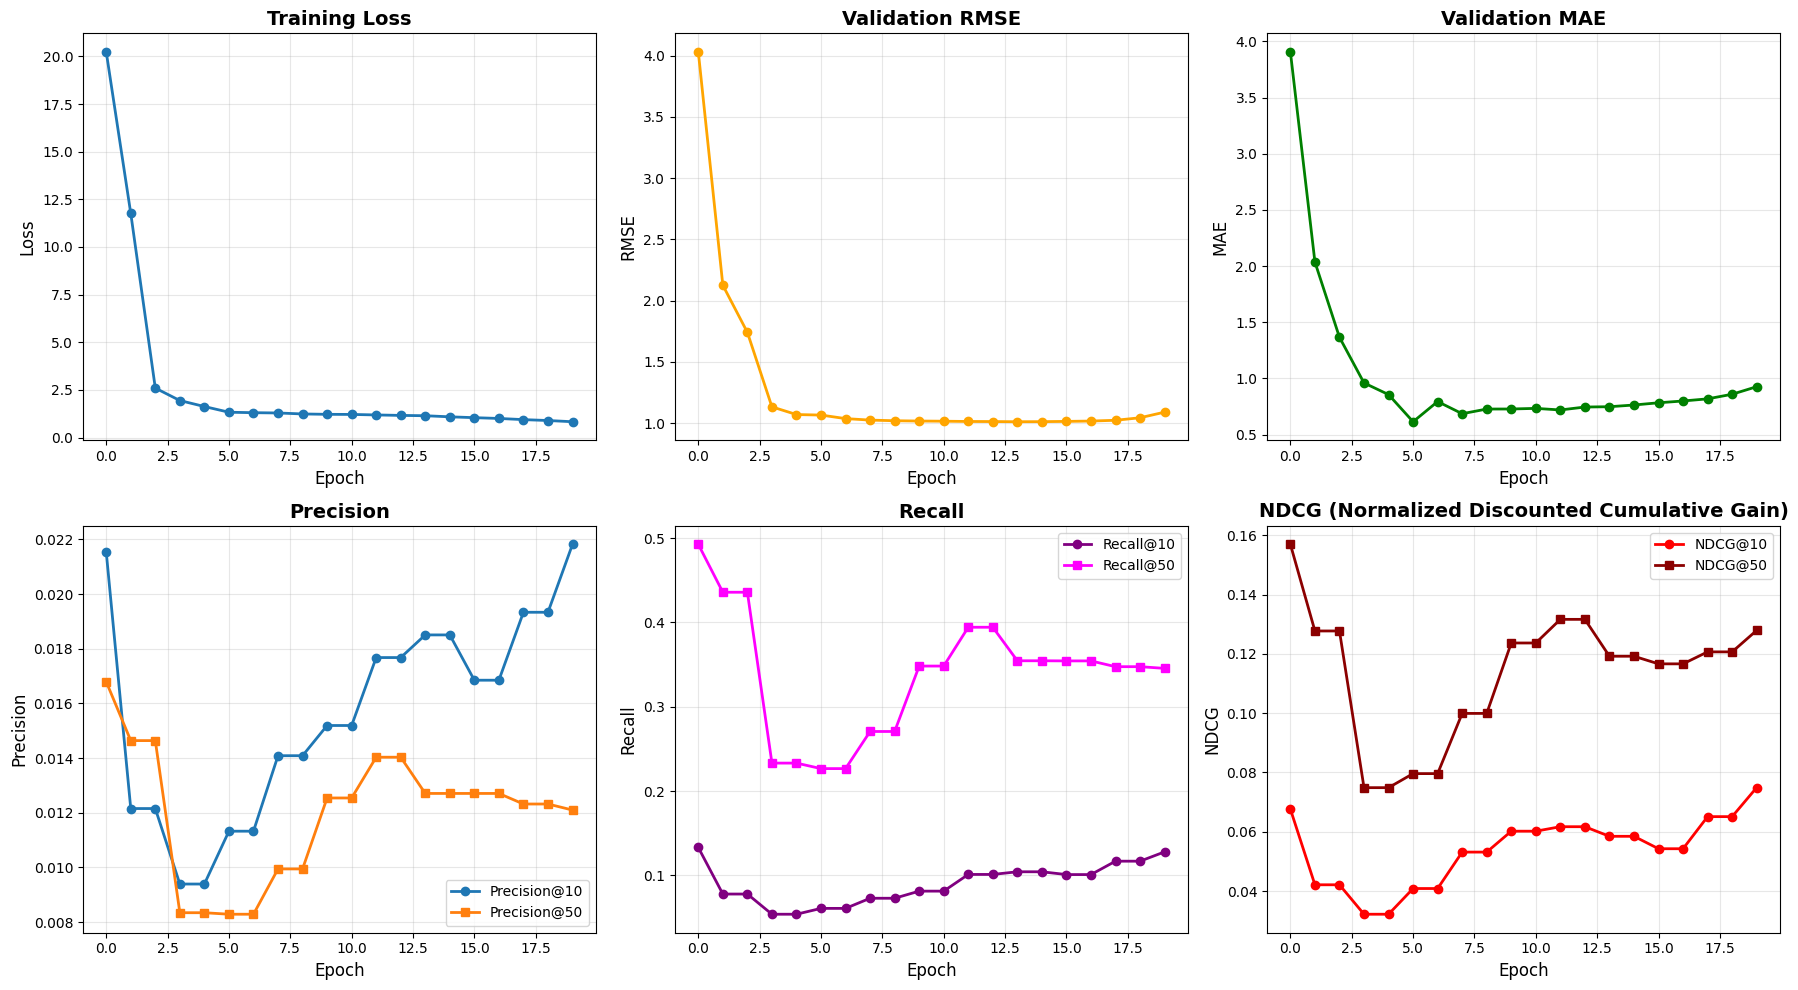

✓ Plot saved to /kaggle/working/training_history.png

FINAL METRICS SUMMARY
Metric                    Best Value     Final Value
----------------------------------------------------------------------
Train Loss                    0.8314          0.8314
Val RMSE                      1.0110          1.0892
Val MAE                       0.6141          0.9259
Precision@10                  0.0218          0.0218
Recall@10                     0.1331          0.1278
NDCG@10                       0.0749          0.0749
Precision@50                  0.0168          0.0121
Recall@50                     0.4926          0.3455
NDCG@50                       0.1569          0.1279


In [21]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 16: PLOT TRAINING HISTORY
# ═══════════════════════════════════════════════════════════════════════════
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))

# Create 2x3 grid
# Row 1: Loss and Rating metrics
ax1 = plt.subplot(2, 3, 1)
ax2 = plt.subplot(2, 3, 2)
ax3 = plt.subplot(2, 3, 3)

# Row 2: Ranking metrics
ax4 = plt.subplot(2, 3, 4)
ax5 = plt.subplot(2, 3, 5)
ax6 = plt.subplot(2, 3, 6)

# Plot 1: Training Loss
ax1.plot(history['train_loss'], marker='o', linewidth=2, markersize=6)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Validation RMSE
ax2.plot(history['val_rmse'], marker='o', color='orange', linewidth=2, markersize=6)
ax2.set_title('Validation RMSE', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Validation MAE
ax3.plot(history['val_mae'], marker='o', color='green', linewidth=2, markersize=6)
ax3.set_title('Validation MAE', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('MAE', fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Precision
ax4.plot(history['precision@10'], marker='o', label='Precision@10', linewidth=2, markersize=6)
ax4.plot(history['precision@50'], marker='s', label='Precision@50', linewidth=2, markersize=6)
ax4.set_title('Precision', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Plot 5: Recall
ax5.plot(history['recall@10'], marker='o', label='Recall@10', color='purple', linewidth=2, markersize=6)
ax5.plot(history['recall@50'], marker='s', label='Recall@50', color='magenta', linewidth=2, markersize=6)
ax5.set_title('Recall', fontsize=14, fontweight='bold')
ax5.set_xlabel('Epoch', fontsize=12)
ax5.set_ylabel('Recall', fontsize=12)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Plot 6: NDCG
ax6.plot(history['ndcg@10'], marker='o', label='NDCG@10', color='red', linewidth=2, markersize=6)
ax6.plot(history['ndcg@50'], marker='s', label='NDCG@50', color='darkred', linewidth=2, markersize=6)
ax6.set_title('NDCG (Normalized Discounted Cumulative Gain)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Epoch', fontsize=12)
ax6.set_ylabel('NDCG', fontsize=12)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to {OUTPUT_DIR}/training_history.png")

# Print final metrics summary
print("\n" + "="*70)
print("FINAL METRICS SUMMARY")
print("="*70)
print(f"{'Metric':<20} {'Best Value':>15} {'Final Value':>15}")
print("-"*70)
print(f"{'Train Loss':<20} {min(history['train_loss']):>15.4f} {history['train_loss'][-1]:>15.4f}")
print(f"{'Val RMSE':<20} {min(history['val_rmse']):>15.4f} {history['val_rmse'][-1]:>15.4f}")
print(f"{'Val MAE':<20} {min(history['val_mae']):>15.4f} {history['val_mae'][-1]:>15.4f}")
print(f"{'Precision@10':<20} {max(history['precision@10']):>15.4f} {history['precision@10'][-1]:>15.4f}")
print(f"{'Recall@10':<20} {max(history['recall@10']):>15.4f} {history['recall@10'][-1]:>15.4f}")
print(f"{'NDCG@10':<20} {max(history['ndcg@10']):>15.4f} {history['ndcg@10'][-1]:>15.4f}")
print(f"{'Precision@50':<20} {max(history['precision@50']):>15.4f} {history['precision@50'][-1]:>15.4f}")
print(f"{'Recall@50':<20} {max(history['recall@50']):>15.4f} {history['recall@50'][-1]:>15.4f}")
print(f"{'NDCG@50':<20} {max(history['ndcg@50']):>15.4f} {history['ndcg@50'][-1]:>15.4f}")
print("="*70)


In [22]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 18: SAVE RESULTS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

# ═══════════════════════════════════════════════════════════════════════════
# CELL 18: SAVE RESULTS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

# Load best model checkpoint to get best metrics
checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=False)
best_metrics = checkpoint.get('metrics', {})

summary = {
    'dataset': 'Amazon 2023 - Handmade Products',
    'max_reviews': MAX_REVIEWS,
    'n_users': n_users,
    'n_items': n_items,
    'n_interactions_train': len(train_df),
    'n_interactions_val': len(val_df),
    'n_interactions_total': len(df),
    'sparsity': float(1 - len(df)/(n_users*n_items)),
    'embed_dim': EMBED_DIM,
    'n_layers': N_LAYERS,
    'epochs': EPOCHS,
    'batch_size': TRAIN_BATCH_SIZE,
    'learning_rate': LR,
    
    # Best metrics (from saved checkpoint)
    'best_epoch': checkpoint['epoch'],
    'best_rmse': float(checkpoint['rmse']),
    'best_ndcg@10': float(checkpoint.get('ndcg@10', 0)),
    'best_precision@10': float(best_metrics.get('precision@10', 0)),
    'best_recall@10': float(best_metrics.get('recall@10', 0)),
    'best_precision@50': float(best_metrics.get('precision@50', 0)),
    'best_recall@50': float(best_metrics.get('recall@50', 0)),
    'best_ndcg@50': float(best_metrics.get('ndcg@50', 0)),
    
    # Final metrics (from last epoch)
    'final_train_loss': float(history['train_loss'][-1]),
    'final_val_rmse': float(history['val_rmse'][-1]),
    'final_val_mae': float(history['val_mae'][-1]),
    'final_precision@10': float(history['precision@10'][-1]),
    'final_recall@10': float(history['recall@10'][-1]),
    'final_ndcg@10': float(history['ndcg@10'][-1]),
    'final_precision@50': float(history['precision@50'][-1]),
    'final_recall@50': float(history['recall@50'][-1]),
    'final_ndcg@50': float(history['ndcg@50'][-1]),
    
    'model_path': MODEL_SAVE_PATH
}

import json
with open(f'{OUTPUT_DIR}/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)
print("\n📊 DATASET INFO")
print("-"*70)
print(f"Total interactions: {summary['n_interactions_total']:,}")
print(f"Train interactions: {summary['n_interactions_train']:,}")
print(f"Val interactions: {summary['n_interactions_val']:,}")
print(f"Users: {summary['n_users']:,}")
print(f"Items: {summary['n_items']:,}")
print(f"Sparsity: {summary['sparsity']:.6f}")

print("\n🎯 BEST METRICS (Epoch {})".format(summary['best_epoch'] + 1))
print("-"*70)
print(f"RMSE:         {summary['best_rmse']:.4f}")
print(f"Precision@10: {summary['best_precision@10']:.4f}")
print(f"Recall@10:    {summary['best_recall@10']:.4f}")
print(f"NDCG@10:      {summary['best_ndcg@10']:.4f}")
print(f"Precision@50: {summary['best_precision@50']:.4f}")
print(f"Recall@50:    {summary['best_recall@50']:.4f}")
print(f"NDCG@50:      {summary['best_ndcg@50']:.4f}")

print("\n📈 FINAL METRICS (Last Epoch)")
print("-"*70)
print(f"Train Loss:   {summary['final_train_loss']:.4f}")
print(f"Val RMSE:     {summary['final_val_rmse']:.4f}")
print(f"Val MAE:      {summary['final_val_mae']:.4f}")
print(f"Precision@10: {summary['final_precision@10']:.4f}")
print(f"Recall@10:    {summary['final_recall@10']:.4f}")
print(f"NDCG@10:      {summary['final_ndcg@10']:.4f}")
print(f"Precision@50: {summary['final_precision@50']:.4f}")
print(f"Recall@50:    {summary['final_recall@50']:.4f}")
print(f"NDCG@50:      {summary['final_ndcg@50']:.4f}")

print("\n💾 OUTPUT FILES")
print("-"*70)
print(f"Model: {MODEL_SAVE_PATH}")
print(f"Summary: {OUTPUT_DIR}/summary.json")
print(f"Plot: {OUTPUT_DIR}/training_history.png")

print("\n" + "="*70)
print("🎉 ALL DONE!")
print("="*70)
print("SUMMARY")
print("="*70)
for key, value in summary.items():
    print(f"{key}: {value}")

print(f"\n✓ Summary saved to {OUTPUT_DIR}/summary.json")
print(f"✓ Model saved to {MODEL_SAVE_PATH}")
print("\n🎉 All done!")

# ═══════════════════════════════════════════════════════════════════════════
# END OF NOTEBOOK
# ═══════════════════════════════════════════════════════════════════════════


EXPERIMENT SUMMARY

📊 DATASET INFO
----------------------------------------------------------------------
Total interactions: 6,375
Train interactions: 5,100
Val interactions: 1,275
Users: 1,631
Items: 1,329
Sparsity: 0.997059

🎯 BEST METRICS (Epoch 20)
----------------------------------------------------------------------
RMSE:         1.0892
Precision@10: 0.0218
Recall@10:    0.1278
NDCG@10:      0.0749
Precision@50: 0.0121
Recall@50:    0.3455
NDCG@50:      0.1279

📈 FINAL METRICS (Last Epoch)
----------------------------------------------------------------------
Train Loss:   0.8314
Val RMSE:     1.0892
Val MAE:      0.9259
Precision@10: 0.0218
Recall@10:    0.1278
NDCG@10:      0.0749
Precision@50: 0.0121
Recall@50:    0.3455
NDCG@50:      0.1279

💾 OUTPUT FILES
----------------------------------------------------------------------
Model: /kaggle/working/lightgcl_best.pth
Summary: /kaggle/working/summary.json
Plot: /kaggle/working/training_history.png

🎉 ALL DONE!
SUMMARY
dataset


EXPORTING DETAILED RESULTS TO CSV

Generating predictions for all test users...


Processing users:   0%|          | 0/362 [00:00<?, ?it/s]


✓ Detailed results saved to: /kaggle/working/detailed_results.csv
✓ Total users: 362

SUMMARY STATISTICS

📊 User Statistics:
  Total users evaluated: 362
  Avg train items per user: 2.59
  Avg test items per user: 1.86

🎯 Hit Statistics:
  Avg hits@10 per user: 0.22
  Avg hits@50 per user: 0.60
  Users with at least 1 hit@10: 77 (21.3%)
  Users with at least 1 hit@50: 182 (50.3%)

📈 Metrics Distribution:

Precision@10:
  Mean: 0.0218
  Median: 0.0000
  Std: 0.0427

Recall@10:
  Mean: 0.1278
  Median: 0.0000
  Std: 0.2794

NDCG@10:
  Mean: 0.0749
  Median: 0.0000
  Std: 0.1672

TOP 10 BEST PERFORMING USERS (by NDCG@10)

                     user_id  n_train_items  n_test_items  n_hits_top10  precision@10  recall@10  ndcg@10
AGOCGNCMX5ERMMXJUYIWEVHJLA5Q              2             1             1           0.1        1.0 1.000000
AGZEZQNGJRLAB5CB3NBKP455GDPA              3             1             1           0.1        1.0 1.000000
AFIC7AJFLGRX26IET6JDOTON372Q              3           

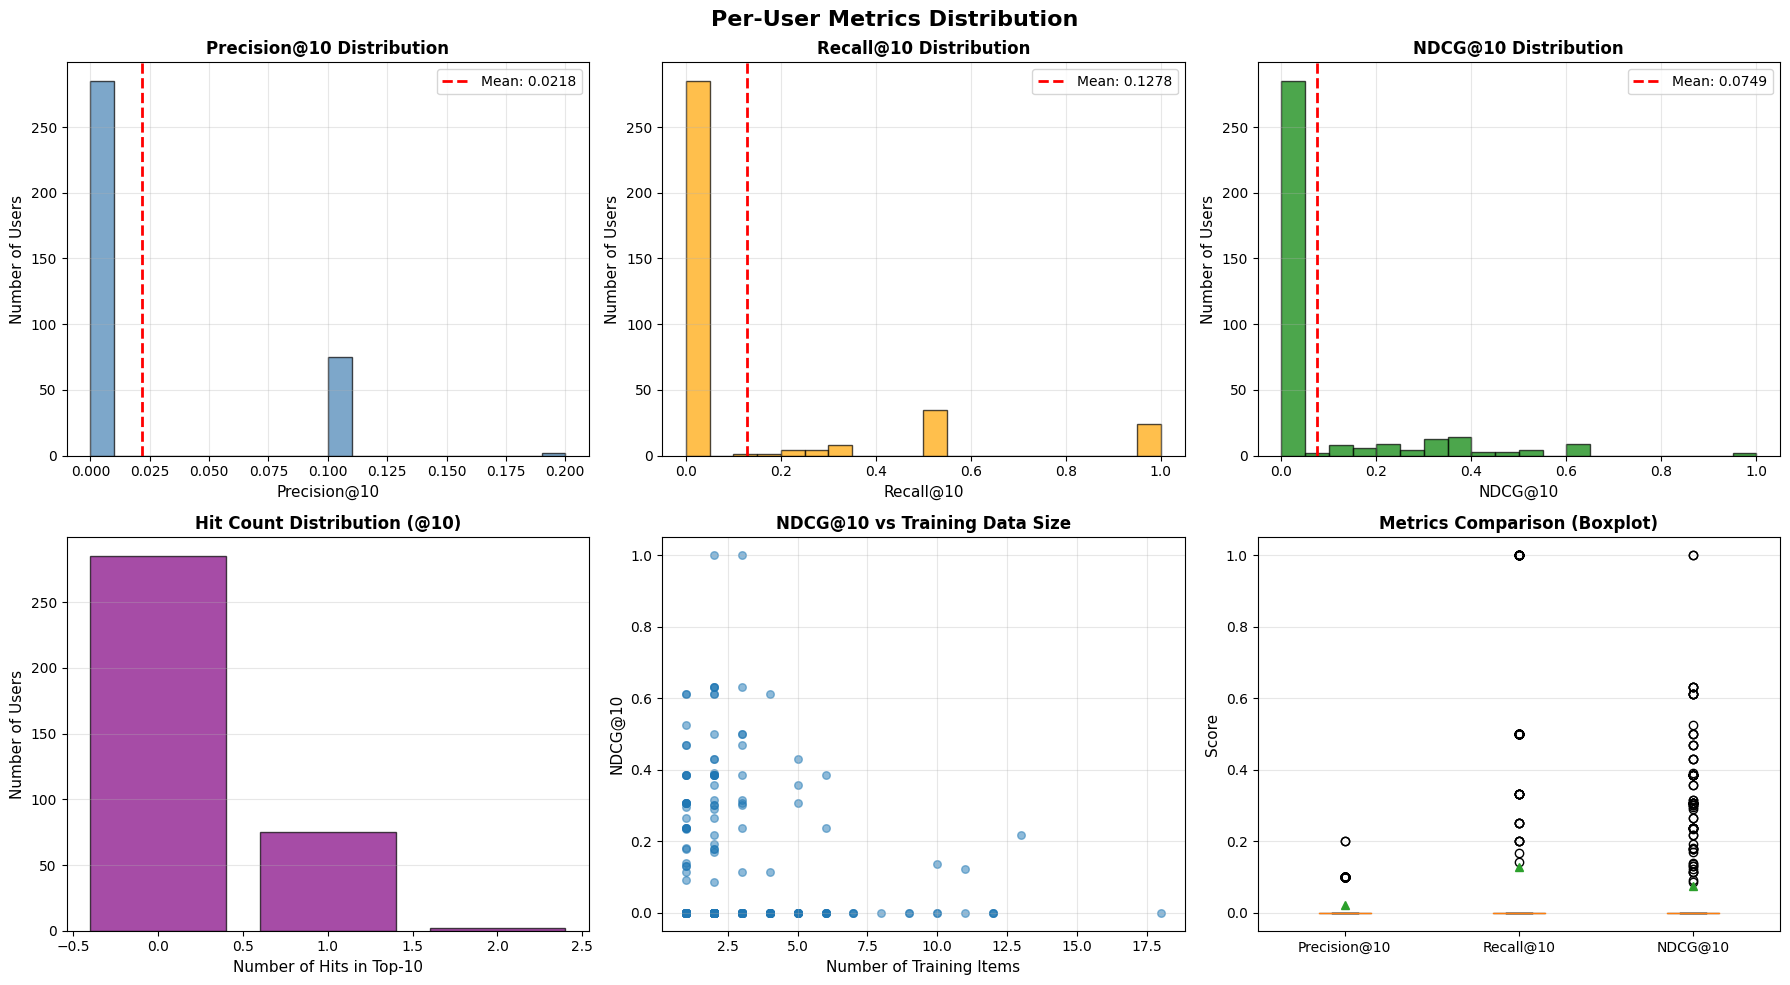


✓ Metrics distribution plot saved to: /kaggle/working/metrics_distribution.png

EXPORT COMPLETE!

📁 Generated Files:
  1. /kaggle/working/detailed_results.csv - Full results (19 columns)
  2. /kaggle/working/results_simplified.csv - Key columns (7 columns)
  3. /kaggle/working/metrics_distribution.png - Distribution plots

✅ All done!


In [23]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 19: EXPORT DETAILED RESULTS TO CSV
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("EXPORTING DETAILED RESULTS TO CSV")
print("="*70)

# Load best model
checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get embeddings
with torch.no_grad():
    user_emb, item_emb = model.lightgcl(norm_adj_tensor)

# Prepare results list
results = []

print("\nGenerating predictions for all test users...")

for user_idx in tqdm(test_user_item_dict.keys(), desc="Processing users"):
    # Get user's training items
    train_items = train_user_item_dict.get(user_idx, [])
    test_items = test_user_item_dict.get(user_idx, [])
    
    # Compute scores
    user_vector = user_emb[user_idx].unsqueeze(0)
    scores = (user_vector @ item_emb.T).squeeze().cpu().numpy()
    
    # Filter out training items
    scores[train_items] = -np.inf
    
    # Get top-K recommendations for different K values
    top_10 = np.argsort(scores)[-10:][::-1].tolist()
    top_50 = np.argsort(scores)[-50:][::-1].tolist()
    
    # Calculate metrics
    precision_10 = precision_at_k(test_items, top_10, 10)
    recall_10 = recall_at_k(test_items, top_10, 10)
    ndcg_10 = ndcg_at_k(test_items, top_10, 10)
    
    precision_50 = precision_at_k(test_items, top_50, 50)
    recall_50 = recall_at_k(test_items, top_50, 50)
    ndcg_50 = ndcg_at_k(test_items, top_50, 50)
    
    # Get original IDs
    original_user_id = preprocessor.user_encoder.inverse_transform([user_idx])[0]
    original_train_items = [preprocessor.item_encoder.inverse_transform([item])[0] for item in train_items]
    original_test_items = [preprocessor.item_encoder.inverse_transform([item])[0] for item in test_items]
    original_top_10 = [preprocessor.item_encoder.inverse_transform([item])[0] for item in top_10]
    original_top_50 = [preprocessor.item_encoder.inverse_transform([item])[0] for item in top_50]
    
    # Get hits
    hits_10 = [item for item in top_10 if item in test_items]
    hits_50 = [item for item in top_50 if item in test_items]
    original_hits_10 = [preprocessor.item_encoder.inverse_transform([item])[0] for item in hits_10]
    original_hits_50 = [preprocessor.item_encoder.inverse_transform([item])[0] for item in hits_50]
    
    # Store results
    results.append({
        'user_id': original_user_id,
        'user_idx': user_idx,
        'n_train_items': len(train_items),
        'n_test_items': len(test_items),
        
        # Predictions
        'recommended_items_top10': '|'.join(original_top_10),
        'recommended_items_top50': '|'.join(original_top_50),
        
        # Ground truth
        'actual_items': '|'.join(original_test_items),
        'train_items': '|'.join(original_train_items),
        
        # Hits
        'hits_top10': '|'.join(original_hits_10),
        'hits_top50': '|'.join(original_hits_50),
        'n_hits_top10': len(hits_10),
        'n_hits_top50': len(hits_50),
        
        # Metrics @10
        'precision@10': precision_10,
        'recall@10': recall_10,
        'ndcg@10': ndcg_10,
        
        # Metrics @50
        'precision@50': precision_50,
        'recall@50': recall_50,
        'ndcg@50': ndcg_50,
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Sort by NDCG@10 descending
results_df = results_df.sort_values('ndcg@10', ascending=False).reset_index(drop=True)

# Save to CSV
csv_path = f'{OUTPUT_DIR}/detailed_results.csv'
results_df.to_csv(csv_path, index=False)

print(f"\n✓ Detailed results saved to: {csv_path}")
print(f"✓ Total users: {len(results_df)}")

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print("\n📊 User Statistics:")
print(f"  Total users evaluated: {len(results_df)}")
print(f"  Avg train items per user: {results_df['n_train_items'].mean():.2f}")
print(f"  Avg test items per user: {results_df['n_test_items'].mean():.2f}")

print("\n🎯 Hit Statistics:")
print(f"  Avg hits@10 per user: {results_df['n_hits_top10'].mean():.2f}")
print(f"  Avg hits@50 per user: {results_df['n_hits_top50'].mean():.2f}")
print(f"  Users with at least 1 hit@10: {(results_df['n_hits_top10'] > 0).sum()} ({(results_df['n_hits_top10'] > 0).sum()/len(results_df)*100:.1f}%)")
print(f"  Users with at least 1 hit@50: {(results_df['n_hits_top50'] > 0).sum()} ({(results_df['n_hits_top50'] > 0).sum()/len(results_df)*100:.1f}%)")

print("\n📈 Metrics Distribution:")
print("\nPrecision@10:")
print(f"  Mean: {results_df['precision@10'].mean():.4f}")
print(f"  Median: {results_df['precision@10'].median():.4f}")
print(f"  Std: {results_df['precision@10'].std():.4f}")

print("\nRecall@10:")
print(f"  Mean: {results_df['recall@10'].mean():.4f}")
print(f"  Median: {results_df['recall@10'].median():.4f}")
print(f"  Std: {results_df['recall@10'].std():.4f}")

print("\nNDCG@10:")
print(f"  Mean: {results_df['ndcg@10'].mean():.4f}")
print(f"  Median: {results_df['ndcg@10'].median():.4f}")
print(f"  Std: {results_df['ndcg@10'].std():.4f}")

# Show top 10 best performing users
print("\n" + "="*70)
print("TOP 10 BEST PERFORMING USERS (by NDCG@10)")
print("="*70)
print("\n" + results_df[['user_id', 'n_train_items', 'n_test_items', 'n_hits_top10', 
                          'precision@10', 'recall@10', 'ndcg@10']].head(10).to_string(index=False))

# Show top 10 worst performing users
print("\n" + "="*70)
print("TOP 10 WORST PERFORMING USERS (by NDCG@10)")
print("="*70)
print("\n" + results_df[['user_id', 'n_train_items', 'n_test_items', 'n_hits_top10', 
                          'precision@10', 'recall@10', 'ndcg@10']].tail(10).to_string(index=False))

# Create simplified CSV
simplified_df = results_df[['user_id', 'recommended_items_top10', 'actual_items', 
                             'hits_top10', 'precision@10', 'recall@10', 'ndcg@10']].copy()
simplified_csv_path = f'{OUTPUT_DIR}/results_simplified.csv'
simplified_df.to_csv(simplified_csv_path, index=False)

print(f"\n✓ Simplified results saved to: {simplified_csv_path}")


# ═══════════════════════════════════════════════════════════════════════════
# CELL 20: VISUALIZE METRICS DISTRIBUTION
# ═══════════════════════════════════════════════════════════════════════════

import matplotlib.pyplot as plt

print("\n" + "="*70)
print("VISUALIZING METRICS DISTRIBUTION")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Per-User Metrics Distribution', fontsize=16, fontweight='bold')

# Plot 1: Precision@10
ax1 = axes[0, 0]
ax1.hist(results_df['precision@10'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(results_df['precision@10'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {results_df["precision@10"].mean():.4f}')
ax1.set_xlabel('Precision@10', fontsize=11)
ax1.set_ylabel('Number of Users', fontsize=11)
ax1.set_title('Precision@10 Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Recall@10
ax2 = axes[0, 1]
ax2.hist(results_df['recall@10'], bins=20, edgecolor='black', alpha=0.7, color='orange')
ax2.axvline(results_df['recall@10'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {results_df["recall@10"].mean():.4f}')
ax2.set_xlabel('Recall@10', fontsize=11)
ax2.set_ylabel('Number of Users', fontsize=11)
ax2.set_title('Recall@10 Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: NDCG@10
ax3 = axes[0, 2]
ax3.hist(results_df['ndcg@10'], bins=20, edgecolor='black', alpha=0.7, color='green')
ax3.axvline(results_df['ndcg@10'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {results_df["ndcg@10"].mean():.4f}')
ax3.set_xlabel('NDCG@10', fontsize=11)
ax3.set_ylabel('Number of Users', fontsize=11)
ax3.set_title('NDCG@10 Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Number of hits@10
ax4 = axes[1, 0]
hits_counts = results_df['n_hits_top10'].value_counts().sort_index()
ax4.bar(hits_counts.index, hits_counts.values, edgecolor='black', alpha=0.7, color='purple')
ax4.set_xlabel('Number of Hits in Top-10', fontsize=11)
ax4.set_ylabel('Number of Users', fontsize=11)
ax4.set_title('Hit Count Distribution (@10)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Train vs Test items
ax5 = axes[1, 1]
ax5.scatter(results_df['n_train_items'], results_df['ndcg@10'], alpha=0.5, s=30)
ax5.set_xlabel('Number of Training Items', fontsize=11)
ax5.set_ylabel('NDCG@10', fontsize=11)
ax5.set_title('NDCG@10 vs Training Data Size', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Metrics comparison boxplot
ax6 = axes[1, 2]
metrics_data = [results_df['precision@10'], results_df['recall@10'], results_df['ndcg@10']]
bp = ax6.boxplot(metrics_data, labels=['Precision@10', 'Recall@10', 'NDCG@10'], 
                  patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['steelblue', 'orange', 'green']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax6.set_ylabel('Score', fontsize=11)
ax6.set_title('Metrics Comparison (Boxplot)', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/metrics_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Metrics distribution plot saved to: {OUTPUT_DIR}/metrics_distribution.png")

print("\n" + "="*70)
print("EXPORT COMPLETE!")
print("="*70)
print(f"\n📁 Generated Files:")
print(f"  1. {OUTPUT_DIR}/detailed_results.csv - Full results (19 columns)")
print(f"  2. {OUTPUT_DIR}/results_simplified.csv - Key columns (7 columns)")
print(f"  3. {OUTPUT_DIR}/metrics_distribution.png - Distribution plots")
print("\n✅ All done!")

In [24]:
# ═══════════════════════════════════════════════════════════════════════════════
# CELL: EVALUATE ON TEST.CSV
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("EVALUATING ON TEST.CSV")
print("="*70)

# Load test.csv
test_csv_path = '/kaggle/input/web-mining/test.csv'  # Adjust path if needed
print(f"\nLoading test data from: {test_csv_path}")

test_df_raw = pd.read_csv(test_csv_path)
print(f"✓ Loaded {len(test_df_raw)} test interactions")
print(f"\nTest data columns: {list(test_df_raw.columns)}")
print(f"\nSample test data:")
print(test_df_raw.head(3))

# ─────────────────────────────────────────────────────────────────────────────
# PREPROCESSING TEST DATA
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "-"*70)
print("Preprocessing test data...")
print("-"*70)

# Filter test data to only include users and items seen during training
test_df = test_df_raw.copy()

# Get users and items from training
train_users = set(preprocessor.user_encoder.classes_)
train_items = set(preprocessor.item_encoder.classes_)

print(f"\nTraining users: {len(train_users)}")
print(f"Training items: {len(train_items)}")

# Filter test data
test_df = test_df[test_df['user_id'].isin(train_users)]
test_df = test_df[test_df['parent_asin'].isin(train_items)]

print(f"\nAfter filtering:")
print(f"  Test interactions: {len(test_df)}")
print(f"  Unique users: {test_df['user_id'].nunique()}")
print(f"  Unique items: {test_df['parent_asin'].nunique()}")

if len(test_df) == 0:
    print("\n⚠️ WARNING: No overlapping users/items between train and test!")
    print("This might happen if:")
    print("  1. test.csv is from a different dataset")
    print("  2. test.csv uses different IDs")
    print("  3. There's no overlap between train and test periods")
else:
    # Encode test data
    print("\nEncoding test data...")
    test_df['user_idx'] = preprocessor.user_encoder.transform(test_df['user_id'])
    test_df['item_idx'] = preprocessor.item_encoder.transform(test_df['parent_asin'])
    
    # Merge with metadata
    print("Merging with metadata...")
    test_df = test_df.merge(
        meta_df[['parent_asin', 'title', 'main_category']],
        on='parent_asin',
        how='left',
        suffixes=('_review', '_product')
    )
    
    # Handle missing values
    test_df['rating'] = test_df['rating'].fillna(test_df['rating'].mean())
    test_df['text'] = test_df['text'].fillna('')
    test_df['title_review'] = test_df['title_review'].fillna('')
    test_df['title_product'] = test_df['title_product'].fillna('')
    test_df['main_category'] = test_df['main_category'].fillna('Unknown')
    
    # Encode categories
    # Handle unknown categories by adding them or using a default
    known_categories = set(preprocessor.cat_encoder.classes_)
    test_df['main_category'] = test_df['main_category'].apply(
        lambda x: x if x in known_categories else 'Unknown'
    )
    test_df['category_idx'] = preprocessor.cat_encoder.transform(test_df['main_category'])
    
    print("✓ Test data preprocessed")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # ENCODE TEXT FEATURES FOR TEST DATA
    # ─────────────────────────────────────────────────────────────────────────────
    
    print("\n" + "-"*70)
    print("Encoding text features for test data...")
    print("-"*70)
    
    encoder = SentenceTransformer('all-MiniLM-L6-v2')
    
    test_texts = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Preparing text"):
        text = f"{row['title_review']} {row['text']} {row['title_product']}"[:512]
        test_texts.append(text)
    
    test_text_features = encoder.encode(
        test_texts,
        batch_size=TEXT_BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True,
        device=device.type
    )
    
    print(f"✓ Test text embeddings: {test_text_features.shape}")
    
    # Free memory
    del encoder
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    # ─────────────────────────────────────────────────────────────────────────────
    # CREATE TEST DATASET AND DATALOADER
    # ─────────────────────────────────────────────────────────────────────────────
    
    print("\n" + "-"*70)
    print("Creating test dataset...")
    print("-"*70)
    
    test_dataset = RecDataset(test_df, test_text_features)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=TRAIN_BATCH_SIZE,
        pin_memory=True if device.type == 'cuda' else False
    )
    
    print(f"✓ Test dataset: {len(test_dataset)} samples")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # EVALUATE RATING PREDICTION ON TEST SET
    # ─────────────────────────────────────────────────────────────────────────────
    
    print("\n" + "="*70)
    print("RATING PREDICTION EVALUATION")
    print("="*70)
    
    # Load best model
    checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_rmse, test_mae = evaluate_rating(model, test_loader, norm_adj_tensor)
    
    print(f"\n📊 Rating Prediction Results:")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE:  {test_mae:.4f}")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # EVALUATE RANKING METRICS ON TEST SET
    # ─────────────────────────────────────────────────────────────────────────────
    
    print("\n" + "="*70)
    print("RANKING METRICS EVALUATION")
    print("="*70)
    
    # Create test user-item dictionary (ground truth)
    # Only consider high ratings (>=3.5) as relevant
    test_df_relevant = test_df[test_df['rating'] >= 3.5].copy()
    test_user_item_dict_new = test_df_relevant.groupby('user_idx')['item_idx'].apply(list).to_dict()
    
    # Filter to only evaluate users with at least 1 relevant item
    test_user_item_dict_new = {
        u: items for u, items in test_user_item_dict_new.items() 
        if len(items) > 0 and u in train_user_item_dict
    }
    
    print(f"\nUsers for ranking evaluation: {len(test_user_item_dict_new)}")
    
    if len(test_user_item_dict_new) > 0:
        # Evaluate ranking metrics
        test_ranking_metrics = evaluate_ranking_metrics(
            model,
            train_user_item_dict,  # For filtering training items
            test_user_item_dict_new,  # Ground truth test items
            norm_adj_tensor,
            n_users,
            n_items,
            k_list=[10, 50]
        )
        
        print("\n📈 Ranking Results:")
        print("-"*70)
        print(f"Precision@10: {test_ranking_metrics['precision@10']:.4f}")
        print(f"Recall@10:    {test_ranking_metrics['recall@10']:.4f}")
        print(f"NDCG@10:      {test_ranking_metrics['ndcg@10']:.4f}")
        print(f"Precision@50: {test_ranking_metrics['precision@50']:.4f}")
        print(f"Recall@50:    {test_ranking_metrics['recall@50']:.4f}")
        print(f"NDCG@50:      {test_ranking_metrics['ndcg@50']:.4f}")
        
        # ─────────────────────────────────────────────────────────────────────────
        # GENERATE DETAILED TEST RESULTS
        # ─────────────────────────────────────────────────────────────────────────
        
        print("\n" + "-"*70)
        print("Generating detailed test results...")
        print("-"*70)
        
        test_results = []
        
        with torch.no_grad():
            user_emb, item_emb = model.lightgcl(norm_adj_tensor)
            
            for user_idx in tqdm(test_user_item_dict_new.keys(), desc="Processing test users"):
                # Get user's training items
                train_items = train_user_item_dict.get(user_idx, [])
                test_items = test_user_item_dict_new.get(user_idx, [])
                
                # Compute scores
                user_vector = user_emb[user_idx].unsqueeze(0)
                scores = (user_vector @ item_emb.T).squeeze().cpu().numpy()
                
                # Filter out training items
                scores[train_items] = -np.inf
                
                # Get top-K recommendations
                top_10 = np.argsort(scores)[-10:][::-1].tolist()
                top_50 = np.argsort(scores)[-50:][::-1].tolist()
                
                # Calculate metrics
                p10 = precision_at_k(test_items, top_10, 10)
                r10 = recall_at_k(test_items, top_10, 10)
                n10 = ndcg_at_k(test_items, top_10, 10)
                
                p50 = precision_at_k(test_items, top_50, 50)
                r50 = recall_at_k(test_items, top_50, 50)
                n50 = ndcg_at_k(test_items, top_50, 50)
                
                # Get original IDs
                original_user_id = preprocessor.user_encoder.inverse_transform([user_idx])[0]
                original_test_items = [preprocessor.item_encoder.inverse_transform([item])[0] for item in test_items]
                original_top_10 = [preprocessor.item_encoder.inverse_transform([item])[0] for item in top_10]
                
                # Get hits
                hits_10 = [item for item in top_10 if item in test_items]
                original_hits_10 = [preprocessor.item_encoder.inverse_transform([item])[0] for item in hits_10]
                
                test_results.append({
                    'user_id': original_user_id,
                    'user_idx': user_idx,
                    'n_train_items': len(train_items),
                    'n_test_items': len(test_items),
                    'recommended_items_top10': '|'.join(original_top_10),
                    'actual_test_items': '|'.join(original_test_items),
                    'hits_top10': '|'.join(original_hits_10),
                    'n_hits_top10': len(hits_10),
                    'precision@10': p10,
                    'recall@10': r10,
                    'ndcg@10': n10,
                    'precision@50': p50,
                    'recall@50': r50,
                    'ndcg@50': n50,
                })
        
        # Create DataFrame
        test_results_df = pd.DataFrame(test_results)
        test_results_df = test_results_df.sort_values('ndcg@10', ascending=False).reset_index(drop=True)
        
        # Save to CSV
        test_csv_output = f'{OUTPUT_DIR}/test_results.csv'
        test_results_df.to_csv(test_csv_output, index=False)
        
        print(f"\n✓ Test results saved to: {test_csv_output}")
        print(f"✓ Total users evaluated: {len(test_results_df)}")
        
        # ─────────────────────────────────────────────────────────────────────────
        # TEST SET SUMMARY
        # ─────────────────────────────────────────────────────────────────────────
        
        print("\n" + "="*70)
        print("TEST SET SUMMARY")
        print("="*70)
        
        print("\n📊 User Statistics:")
        print(f"  Total users evaluated: {len(test_results_df)}")
        print(f"  Avg test items per user: {test_results_df['n_test_items'].mean():.2f}")
        print(f"  Users with at least 1 hit@10: {(test_results_df['n_hits_top10'] > 0).sum()} ({(test_results_df['n_hits_top10'] > 0).sum()/len(test_results_df)*100:.1f}%)")
        
        print("\n📈 Average Metrics:")
        print(f"  Precision@10: {test_results_df['precision@10'].mean():.4f} (±{test_results_df['precision@10'].std():.4f})")
        print(f"  Recall@10:    {test_results_df['recall@10'].mean():.4f} (±{test_results_df['recall@10'].std():.4f})")
        print(f"  NDCG@10:      {test_results_df['ndcg@10'].mean():.4f} (±{test_results_df['ndcg@10'].std():.4f})")
        print(f"  Precision@50: {test_results_df['precision@50'].mean():.4f} (±{test_results_df['precision@50'].std():.4f})")
        print(f"  Recall@50:    {test_results_df['recall@50'].mean():.4f} (±{test_results_df['recall@50'].std():.4f})")
        print(f"  NDCG@50:      {test_results_df['ndcg@50'].mean():.4f} (±{test_results_df['ndcg@50'].std():.4f})")
        
        # Compare with validation results
        print("\n" + "="*70)
        print("COMPARISON: VALIDATION vs TEST")
        print("="*70)
        
        print(f"\n{'Metric':<20} {'Validation':>15} {'Test':>15} {'Difference':>15}")
        print("-"*70)
        print(f"{'RMSE':<20} {best_rmse:>15.4f} {test_rmse:>15.4f} {test_rmse - best_rmse:>15.4f}")
        print(f"{'Precision@10':<20} {history['precision@10'][-1]:>15.4f} {test_ranking_metrics['precision@10']:>15.4f} {test_ranking_metrics['precision@10'] - history['precision@10'][-1]:>15.4f}")
        print(f"{'Recall@10':<20} {history['recall@10'][-1]:>15.4f} {test_ranking_metrics['recall@10']:>15.4f} {test_ranking_metrics['recall@10'] - history['recall@10'][-1]:>15.4f}")
        print(f"{'NDCG@10':<20} {history['ndcg@10'][-1]:>15.4f} {test_ranking_metrics['ndcg@10']:>15.4f} {test_ranking_metrics['ndcg@10'] - history['ndcg@10'][-1]:>15.4f}")
        
        # Show sample predictions
        print("\n" + "="*70)
        print("SAMPLE TEST PREDICTIONS")
        print("="*70)
        print("\nTop 5 best performing users:")
        print(test_results_df[['user_id', 'n_test_items', 'n_hits_top10', 'precision@10', 'recall@10', 'ndcg@10']].head(5).to_string(index=False))
        
        print("\n✅ TEST EVALUATION COMPLETE!")
    else:
        print("\n⚠️ No users available for ranking evaluation")
        print("This could mean:")
        print("  - No users have relevant items (rating >= 3.5) in test set")
        print("  - No overlap between test users and training users")


EVALUATING ON TEST.CSV

Loading test data from: /kaggle/input/web-mining/test.csv
✓ Loaded 3251 test interactions

Test data columns: ['user_id', 'asin', 'parent_asin', 'rating', 'title', 'text', 'helpful_vote', 'verified_purchase', 'timestamp']

Sample test data:
                        user_id        asin parent_asin  rating  \
0  AHKISUS6SE5XI5HG7AVVUBZQZDAQ  B0B3HW7FDF  B0BQ36KZH2     5.0   
1  AHKISUS6SE5XI5HG7AVVUBZQZDAQ  B0BJ26MFK2  B0BN2VJQPP     5.0   
2  AHCOLUDBYT4N5OEU73F6IBXDTHTA  B0BN283C8L  B0BN283C8L     5.0   

                         title  \
0             Classy statement   
1                 Classy piece   
2  Perfect for the Wedding Day   

                                                text  helpful_vote  \
0  I've been shopping around for the perfect pear...             0   
1  I love this pearl necklace! I've been wearing ...             0   
2  Imperfect shapes looks perfect for this design...             0   

   verified_purchase            timestamp  
0  

Preparing text:   0%|          | 0/1660 [00:00<?, ?it/s]

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

✓ Test text embeddings: (1660, 384)

----------------------------------------------------------------------
Creating test dataset...
----------------------------------------------------------------------
✓ Test dataset: 1660 samples

RATING PREDICTION EVALUATION


Evaluating rating:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Rating Prediction Results:
  Test RMSE: 1.0223
  Test MAE:  0.8717

RANKING METRICS EVALUATION

Users for ranking evaluation: 446


Evaluating users:   0%|          | 0/446 [00:00<?, ?it/s]


📈 Ranking Results:
----------------------------------------------------------------------
Precision@10: 0.0177
Recall@10:    0.0915
NDCG@10:      0.0556
Precision@50: 0.0098
Recall@50:    0.2326
NDCG@50:      0.0925

----------------------------------------------------------------------
Generating detailed test results...
----------------------------------------------------------------------


Processing test users:   0%|          | 0/446 [00:00<?, ?it/s]


✓ Test results saved to: /kaggle/working/test_results.csv
✓ Total users evaluated: 446

TEST SET SUMMARY

📊 User Statistics:
  Total users evaluated: 446
  Avg test items per user: 2.31
  Users with at least 1 hit@10: 77 (17.3%)

📈 Average Metrics:
  Precision@10: 0.0177 (±0.0394)
  Recall@10:    0.0915 (±0.2341)
  NDCG@10:      0.0556 (±0.1436)
  Precision@50: 0.0098 (±0.0139)
  Recall@50:    0.2326 (±0.3337)
  NDCG@50:      0.0925 (±0.1516)

COMPARISON: VALIDATION vs TEST

Metric                    Validation            Test      Difference
----------------------------------------------------------------------
RMSE                          1.0892          1.0223         -0.0668
Precision@10                  0.0218          0.0177         -0.0041
Recall@10                     0.1278          0.0915         -0.0364
NDCG@10                       0.0749          0.0556         -0.0193

SAMPLE TEST PREDICTIONS

Top 5 best performing users:
                     user_id  n_test_items  n_hi

In [27]:
# ═══════════════════════════════════════════════════════════════════════════════
# CELL: GENERATE PREDICTIONS FOR TEST SET
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("GENERATING PREDICTIONS FOR TEST SET")
print("="*70)

# Load test.csv
test_csv_path = '/kaggle/input/web-mining/test.csv'  # Adjust path if needed
print(f"\nLoading test data from: {test_csv_path}")

test_df_raw = pd.read_csv(test_csv_path)
print(f"✓ Loaded {len(test_df_raw)} test interactions")
print(f"\nOriginal test data shape: {test_df_raw.shape}")
print(f"Columns: {list(test_df_raw.columns)}")

# ─────────────────────────────────────────────────────────────────────────────
# PREPROCESS TEST DATA
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "-"*70)
print("Preprocessing test data...")
print("-"*70)

test_df = test_df_raw.copy()

# Get training vocabulary
train_users = set(preprocessor.user_encoder.classes_)
train_items = set(preprocessor.item_encoder.classes_)

print(f"\nTraining vocabulary:")
print(f"  Users: {len(train_users)}")
print(f"  Items: {len(train_items)}")

# Check overlap
test_users = set(test_df['user_id'].unique())
test_items = set(test_df['parent_asin'].unique())

user_overlap = test_users & train_users
item_overlap = test_items & train_items

print(f"\nTest data:")
print(f"  Unique users: {len(test_users)}")
print(f"  Unique items: {len(test_items)}")
print(f"\nOverlap with training:")
print(f"  Users: {len(user_overlap)} ({len(user_overlap)/len(test_users)*100:.1f}%)")
print(f"  Items: {len(item_overlap)} ({len(item_overlap)/len(test_items)*100:.1f}%)")

# Mark rows that can be predicted
test_df['can_predict_user'] = test_df['user_id'].isin(train_users)
test_df['can_predict_item'] = test_df['parent_asin'].isin(train_items)
test_df['can_predict'] = test_df['can_predict_user'] & test_df['can_predict_item']

n_predictable = test_df['can_predict'].sum()
print(f"\nPredictable interactions: {n_predictable} ({n_predictable/len(test_df)*100:.1f}%)")

# Separate predictable and unpredictable rows
test_df_predictable = test_df[test_df['can_predict']].copy()
test_df_unpredictable = test_df[~test_df['can_predict']].copy()

print(f"  Predictable rows: {len(test_df_predictable)}")
print(f"  Unpredictable rows: {len(test_df_unpredictable)}")

# ─────────────────────────────────────────────────────────────────────────────
# ENCODE PREDICTABLE DATA
# ─────────────────────────────────────────────────────────────────────────────

if len(test_df_predictable) > 0:
    print("\n" + "-"*70)
    print("Encoding predictable data...")
    print("-"*70)
    
    # Encode IDs
    test_df_predictable['user_idx'] = preprocessor.user_encoder.transform(
        test_df_predictable['user_id']
    )
    test_df_predictable['item_idx'] = preprocessor.item_encoder.transform(
        test_df_predictable['parent_asin']
    )
    
    # Merge with metadata (load if not already loaded)
    print("\nMerging with metadata...")
    
    # Check if meta_df exists
    try:
        meta_df_check = meta_df
    except NameError:
        print("Loading metadata...")
        meta_df = load_jsonl('/kaggle/working/meta_Handmade_Products.jsonl')
    
    test_df_predictable = test_df_predictable.merge(
        meta_df[['parent_asin', 'title', 'main_category']],
        on='parent_asin',
        how='left',
        suffixes=('_review', '_product')
    )
    
    # Handle column names after merge
    # After merge with suffixes, we have:
    # - 'title_review' from test.csv
    # - 'title_product' from meta_df
    
    # Handle missing values
    test_df_predictable['text'] = test_df_predictable['text'].fillna('')
    
    # Check which title columns exist
    if 'title_review' in test_df_predictable.columns:
        test_df_predictable['title_review'] = test_df_predictable['title_review'].fillna('')
    elif 'title' in test_df_predictable.columns:
        test_df_predictable['title_review'] = test_df_predictable['title'].fillna('')
    else:
        test_df_predictable['title_review'] = ''
    
    if 'title_product' in test_df_predictable.columns:
        test_df_predictable['title_product'] = test_df_predictable['title_product'].fillna('')
    else:
        test_df_predictable['title_product'] = ''
    
    test_df_predictable['main_category'] = test_df_predictable['main_category'].fillna('Unknown')
    
    # Encode categories (handle unknown categories)
    known_categories = set(preprocessor.cat_encoder.classes_)
    test_df_predictable['main_category_safe'] = test_df_predictable['main_category'].apply(
        lambda x: x if x in known_categories else 'Unknown'
    )
    test_df_predictable['category_idx'] = preprocessor.cat_encoder.transform(
        test_df_predictable['main_category_safe']
    )
    
    print("✓ Encoding complete")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # ENCODE TEXT FEATURES
    # ─────────────────────────────────────────────────────────────────────────────
    
    print("\n" + "-"*70)
    print("Encoding text features...")
    print("-"*70)
    
    encoder = SentenceTransformer('all-MiniLM-L6-v2')
    
    test_texts = []
    for _, row in tqdm(test_df_predictable.iterrows(), total=len(test_df_predictable), 
                       desc="Preparing text"):
        text = f"{row['title_review']} {row['text']} {row['title_product']}"[:512]
        test_texts.append(text)
    
    test_text_features = encoder.encode(
        test_texts,
        batch_size=TEXT_BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True,
        device=device.type
    )
    
    print(f"✓ Text embeddings: {test_text_features.shape}")
    
    # Free memory
    del encoder
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    
    # ─────────────────────────────────────────────────────────────────────────────
    # CREATE DATASET AND PREDICT
    # ─────────────────────────────────────────────────────────────────────────────
    
    print("\n" + "-"*70)
    print("Creating dataset and making predictions...")
    print("-"*70)
    
    # Create dataset
    test_dataset = RecDataset(test_df_predictable, test_text_features)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=False,  # Important: keep order
        pin_memory=True if device.type == 'cuda' else False
    )
    
    # Load best model
    checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Make predictions
    all_predictions = []
    
    print("\nGenerating predictions...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            user_ids = batch['user_id'].to(device)
            item_ids = batch['item_id'].to(device)
            categories = batch['category'].to(device)
            text_feats = batch['text'].to(device)
            
            pred = model(user_ids, item_ids, text_feats, categories, norm_adj_tensor)
            all_predictions.extend(pred.cpu().numpy())
    
    # Add predictions to dataframe
    test_df_predictable['predicted_rating'] = all_predictions
    
    # Clip predictions to valid rating range (usually 1-5)
    test_df_predictable['predicted_rating'] = test_df_predictable['predicted_rating'].clip(1, 5)
    
    print(f"\n✓ Generated {len(all_predictions)} predictions")
    print(f"  Mean predicted rating: {test_df_predictable['predicted_rating'].mean():.3f}")
    print(f"  Std predicted rating: {test_df_predictable['predicted_rating'].std():.3f}")
    print(f"  Min predicted rating: {test_df_predictable['predicted_rating'].min():.3f}")
    print(f"  Max predicted rating: {test_df_predictable['predicted_rating'].max():.3f}")

# ─────────────────────────────────────────────────────────────────────────────
# HANDLE UNPREDICTABLE DATA (COLD START)
# ─────────────────────────────────────────────────────────────────────────────

if len(test_df_unpredictable) > 0:
    print("\n" + "-"*70)
    print("Handling unpredictable data (cold start)...")
    print("-"*70)
    
    # Strategy for cold start: use global average or item/user averages
    
    # Calculate fallback predictions
    global_mean = df['rating'].mean() if 'rating' in df.columns else 3.5
    
    test_df_unpredictable['predicted_rating'] = global_mean
    test_df_unpredictable['prediction_method'] = 'global_mean'
    
    # Try to use item-specific average if item is known
    if 'parent_asin' in df.columns and 'rating' in df.columns:
        item_means = df.groupby('parent_asin')['rating'].mean().to_dict()
        
        for idx, row in test_df_unpredictable.iterrows():
            if row['parent_asin'] in item_means:
                test_df_unpredictable.loc[idx, 'predicted_rating'] = item_means[row['parent_asin']]
                test_df_unpredictable.loc[idx, 'prediction_method'] = 'item_mean'
    
    # Try to use user-specific average if user is known
    if 'user_id' in df.columns and 'rating' in df.columns:
        user_means = df.groupby('user_id')['rating'].mean().to_dict()
        
        for idx, row in test_df_unpredictable.iterrows():
            if row['user_id'] in user_means and test_df_unpredictable.loc[idx, 'prediction_method'] == 'global_mean':
                test_df_unpredictable.loc[idx, 'predicted_rating'] = user_means[row['user_id']]
                test_df_unpredictable.loc[idx, 'prediction_method'] = 'user_mean'
    
    print(f"✓ Generated {len(test_df_unpredictable)} fallback predictions")
    print(f"  Global mean: {global_mean:.3f}")
    
    # Show prediction method breakdown
    if 'prediction_method' in test_df_unpredictable.columns:
        method_counts = test_df_unpredictable['prediction_method'].value_counts()
        print(f"\nFallback prediction methods:")
        for method, count in method_counts.items():
            print(f"  {method}: {count} ({count/len(test_df_unpredictable)*100:.1f}%)")
    
    # Add prediction_method to predictable data
    test_df_predictable['prediction_method'] = 'model'

# ─────────────────────────────────────────────────────────────────────────────
# COMBINE RESULTS
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "-"*70)
print("Combining results...")
print("-"*70)

# Select relevant columns for output
output_columns = ['user_id', 'asin', 'parent_asin', 'predicted_rating', 'prediction_method']

# Combine predictable and unpredictable
if len(test_df_predictable) > 0 and len(test_df_unpredictable) > 0:
    predictions_df = pd.concat([
        test_df_predictable[output_columns],
        test_df_unpredictable[output_columns]
    ], ignore_index=True)
elif len(test_df_predictable) > 0:
    predictions_df = test_df_predictable[output_columns].copy()
else:
    predictions_df = test_df_unpredictable[output_columns].copy()

# Sort by original order (merge with original index)
predictions_df = test_df[['user_id', 'asin', 'parent_asin']].merge(
    predictions_df,
    on=['user_id', 'asin', 'parent_asin'],
    how='left'
)

# Add actual ratings if they exist in test data
if 'rating' in test_df_raw.columns:
    predictions_df = predictions_df.merge(
        test_df_raw[['user_id', 'asin', 'rating']],
        on=['user_id', 'asin'],
        how='left'
    )
    predictions_df.rename(columns={'rating': 'actual_rating'}, inplace=True)

print(f"✓ Combined predictions: {len(predictions_df)} rows")

# ─────────────────────────────────────────────────────────────────────────────
# SAVE PREDICTIONS
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "-"*70)
print("Saving predictions...")
print("-"*70)

# Save full predictions
predictions_output = f'{OUTPUT_DIR}/test_predictions.csv'
predictions_df.to_csv(predictions_output, index=False)
print(f"✓ Saved to: {predictions_output}")

# Create submission format (if needed)
submission_df = predictions_df[['user_id', 'asin', 'parent_asin', 'predicted_rating']].copy()
submission_output = f'{OUTPUT_DIR}/test_submission.csv'
submission_df.to_csv(submission_output, index=False)
print(f"✓ Submission format saved to: {submission_output}")

# ─────────────────────────────────────────────────────────────────────────────
# EVALUATION (if actual ratings available)
# ─────────────────────────────────────────────────────────────────────────────

if 'actual_rating' in predictions_df.columns:
    print("\n" + "="*70)
    print("PREDICTION EVALUATION")
    print("="*70)
    
    # Filter rows with actual ratings
    eval_df = predictions_df.dropna(subset=['actual_rating', 'predicted_rating'])
    
    if len(eval_df) > 0:
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        
        actual = eval_df['actual_rating'].values
        predicted = eval_df['predicted_rating'].values
        
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        
        print(f"\n📊 Overall Metrics:")
        print(f"  Samples evaluated: {len(eval_df)}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        
        # Breakdown by prediction method
        print(f"\n📈 Metrics by Prediction Method:")
        print("-"*70)
        print(f"{'Method':<20} {'Count':>10} {'RMSE':>10} {'MAE':>10}")
        print("-"*70)
        
        for method in eval_df['prediction_method'].unique():
            method_df = eval_df[eval_df['prediction_method'] == method]
            method_actual = method_df['actual_rating'].values
            method_pred = method_df['predicted_rating'].values
            
            method_rmse = np.sqrt(mean_squared_error(method_actual, method_pred))
            method_mae = mean_absolute_error(method_actual, method_pred)
            
            print(f"{method:<20} {len(method_df):>10} {method_rmse:>10.4f} {method_mae:>10.4f}")
        
        # Rating distribution comparison
        print(f"\n📊 Rating Distribution:")
        print("-"*70)
        print(f"{'Rating':<10} {'Actual':>15} {'Predicted':>15}")
        print("-"*70)
        for rating in sorted(eval_df['actual_rating'].unique()):
            actual_count = (eval_df['actual_rating'] == rating).sum()
            # Count predictions within ±0.5 of rating
            pred_count = ((eval_df['predicted_rating'] >= rating - 0.5) & 
                         (eval_df['predicted_rating'] < rating + 0.5)).sum()
            print(f"{rating:<10.1f} {actual_count:>15} {pred_count:>15}")
    else:
        print("\n⚠️ No rows with both actual and predicted ratings")
else:
    print("\n💡 No actual ratings in test data (pure prediction mode)")

# ─────────────────────────────────────────────────────────────────────────────
# SUMMARY
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "="*70)
print("PREDICTION SUMMARY")
print("="*70)

print(f"\n📁 Input:")
print(f"  Test file: {test_csv_path}")
print(f"  Total rows: {len(test_df_raw)}")

print(f"\n🎯 Predictions:")
print(f"  Model predictions: {len(test_df_predictable)}")
print(f"  Fallback predictions: {len(test_df_unpredictable)}")
print(f"  Total predictions: {len(predictions_df)}")

print(f"\n💾 Output files:")
print(f"  Full predictions: {predictions_output}")
print(f"  Submission format: {submission_output}")

# Show sample predictions
print(f"\n📝 Sample Predictions (first 10 rows):")
print("-"*70)
display_cols = ['user_id', 'parent_asin', 'predicted_rating', 'prediction_method']
if 'actual_rating' in predictions_df.columns:
    display_cols.insert(2, 'actual_rating')
print(predictions_df[display_cols].head(10).to_string(index=False))

print("\n" + "="*70)
print("✅ PREDICTION COMPLETE!")
print("="*70)


GENERATING PREDICTIONS FOR TEST SET

Loading test data from: /kaggle/input/web-mining/test.csv
✓ Loaded 3251 test interactions

Original test data shape: (3251, 9)
Columns: ['user_id', 'asin', 'parent_asin', 'rating', 'title', 'text', 'helpful_vote', 'verified_purchase', 'timestamp']

----------------------------------------------------------------------
Preprocessing test data...
----------------------------------------------------------------------

Training vocabulary:
  Users: 1631
  Items: 1329

Test data:
  Unique users: 1502
  Unique items: 1494

Overlap with training:
  Users: 614 (40.9%)
  Items: 437 (29.3%)

Predictable interactions: 1660 (51.1%)
  Predictable rows: 1660
  Unpredictable rows: 1591

----------------------------------------------------------------------
Encoding predictable data...
----------------------------------------------------------------------

Merging with metadata...
✓ Encoding complete

---------------------------------------------------------------

Preparing text:   0%|          | 0/1660 [00:00<?, ?it/s]

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

✓ Text embeddings: (1660, 384)

----------------------------------------------------------------------
Creating dataset and making predictions...
----------------------------------------------------------------------

Generating predictions...


Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


✓ Generated 1660 predictions
  Mean predicted rating: 4.144
  Std predicted rating: 0.288
  Min predicted rating: 2.309
  Max predicted rating: 5.000

----------------------------------------------------------------------
Handling unpredictable data (cold start)...
----------------------------------------------------------------------
✓ Generated 1591 fallback predictions
  Global mean: 4.570

Fallback prediction methods:
  global_mean: 1252 (78.7%)
  item_mean: 248 (15.6%)
  user_mean: 91 (5.7%)

----------------------------------------------------------------------
Combining results...
----------------------------------------------------------------------
✓ Combined predictions: 10127 rows

----------------------------------------------------------------------
Saving predictions...
----------------------------------------------------------------------
✓ Saved to: /kaggle/working/test_predictions.csv
✓ Submission format saved to: /kaggle/working/test_submission.csv

PREDICTION EVALUA